In [2]:
!pip install pandas numpy matplotlib seaborn

--- 1. Loading Data ---
Successfully loaded data from synthetic_kubernetes_metrics_realistic_v7_3_balanced.csv
Data shape: (100, 38)

--- 2. Initial Data Inspection ---

First 5 rows:
            Timestamp  APIErrorLogRate  API_Server_Request_Latency_Avg  \
0 2025-04-01 00:00:00                0                          65.024   
1 2025-04-01 00:01:00                0                          91.847   
2 2025-04-01 00:02:00                0                          59.824   
3 2025-04-01 00:03:00                0                          63.013   
4 2025-04-01 00:04:00                0                          59.941   

   App_Error_Rate_Avg  App_Latency_Avg  AvgCPURequestCommitRatio  \
0               0.758          145.713                     0.010   
1               0.738          107.893                     0.010   
2               0.429           93.908                     1.118   
3               0.000           99.247                     1.327   
4               3.680          

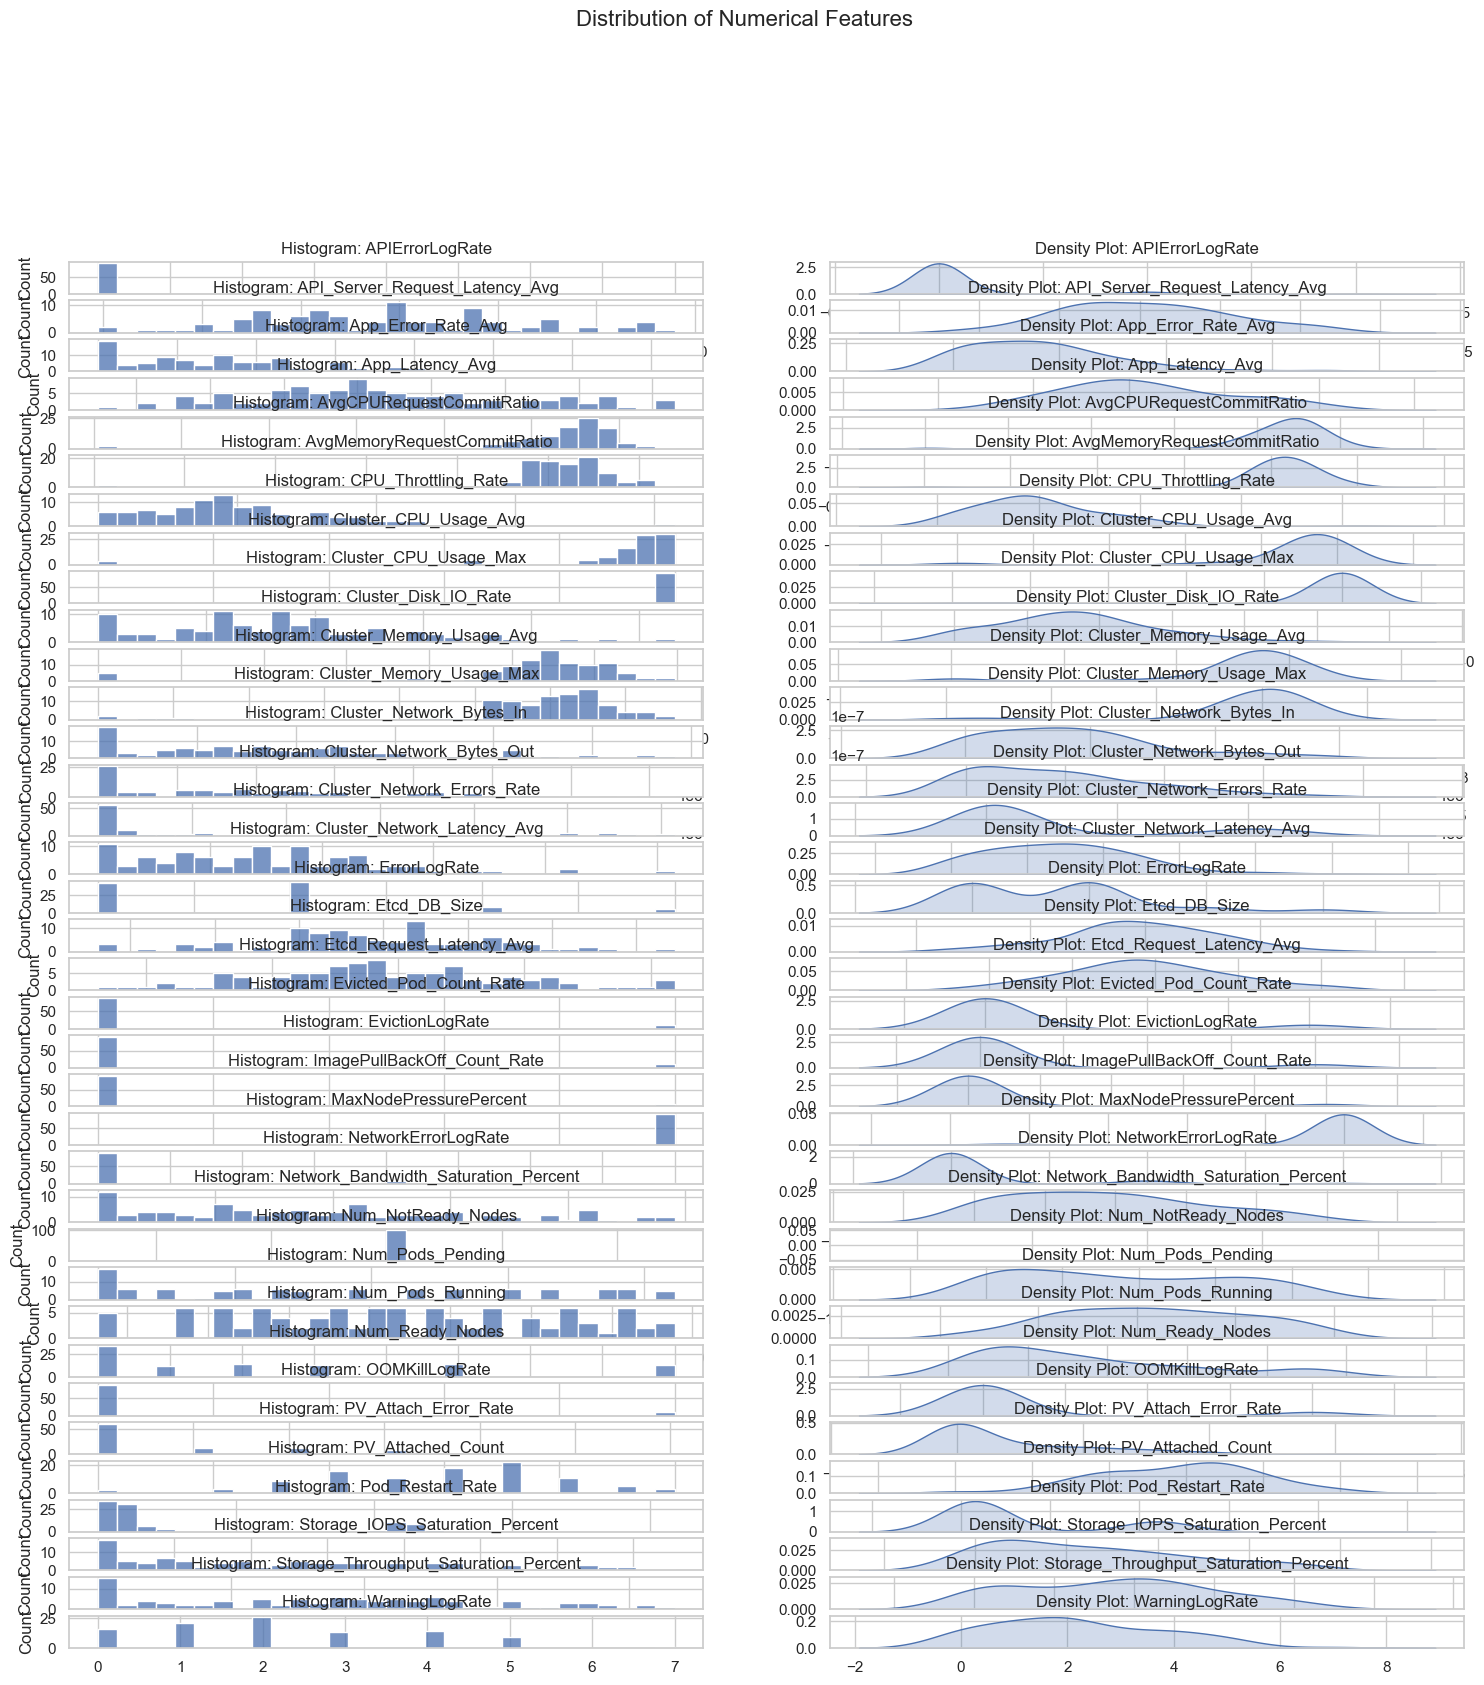


Generating count plots for categorical features...


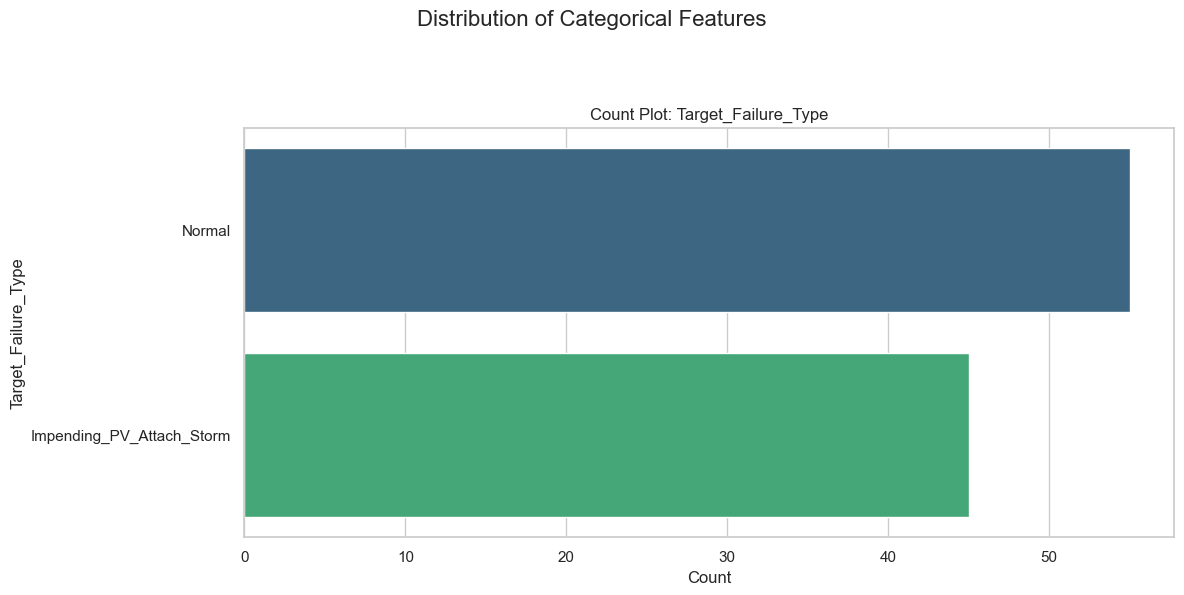


--- 6. Bivariate Analysis ---

Generating correlation heatmap for numerical features...


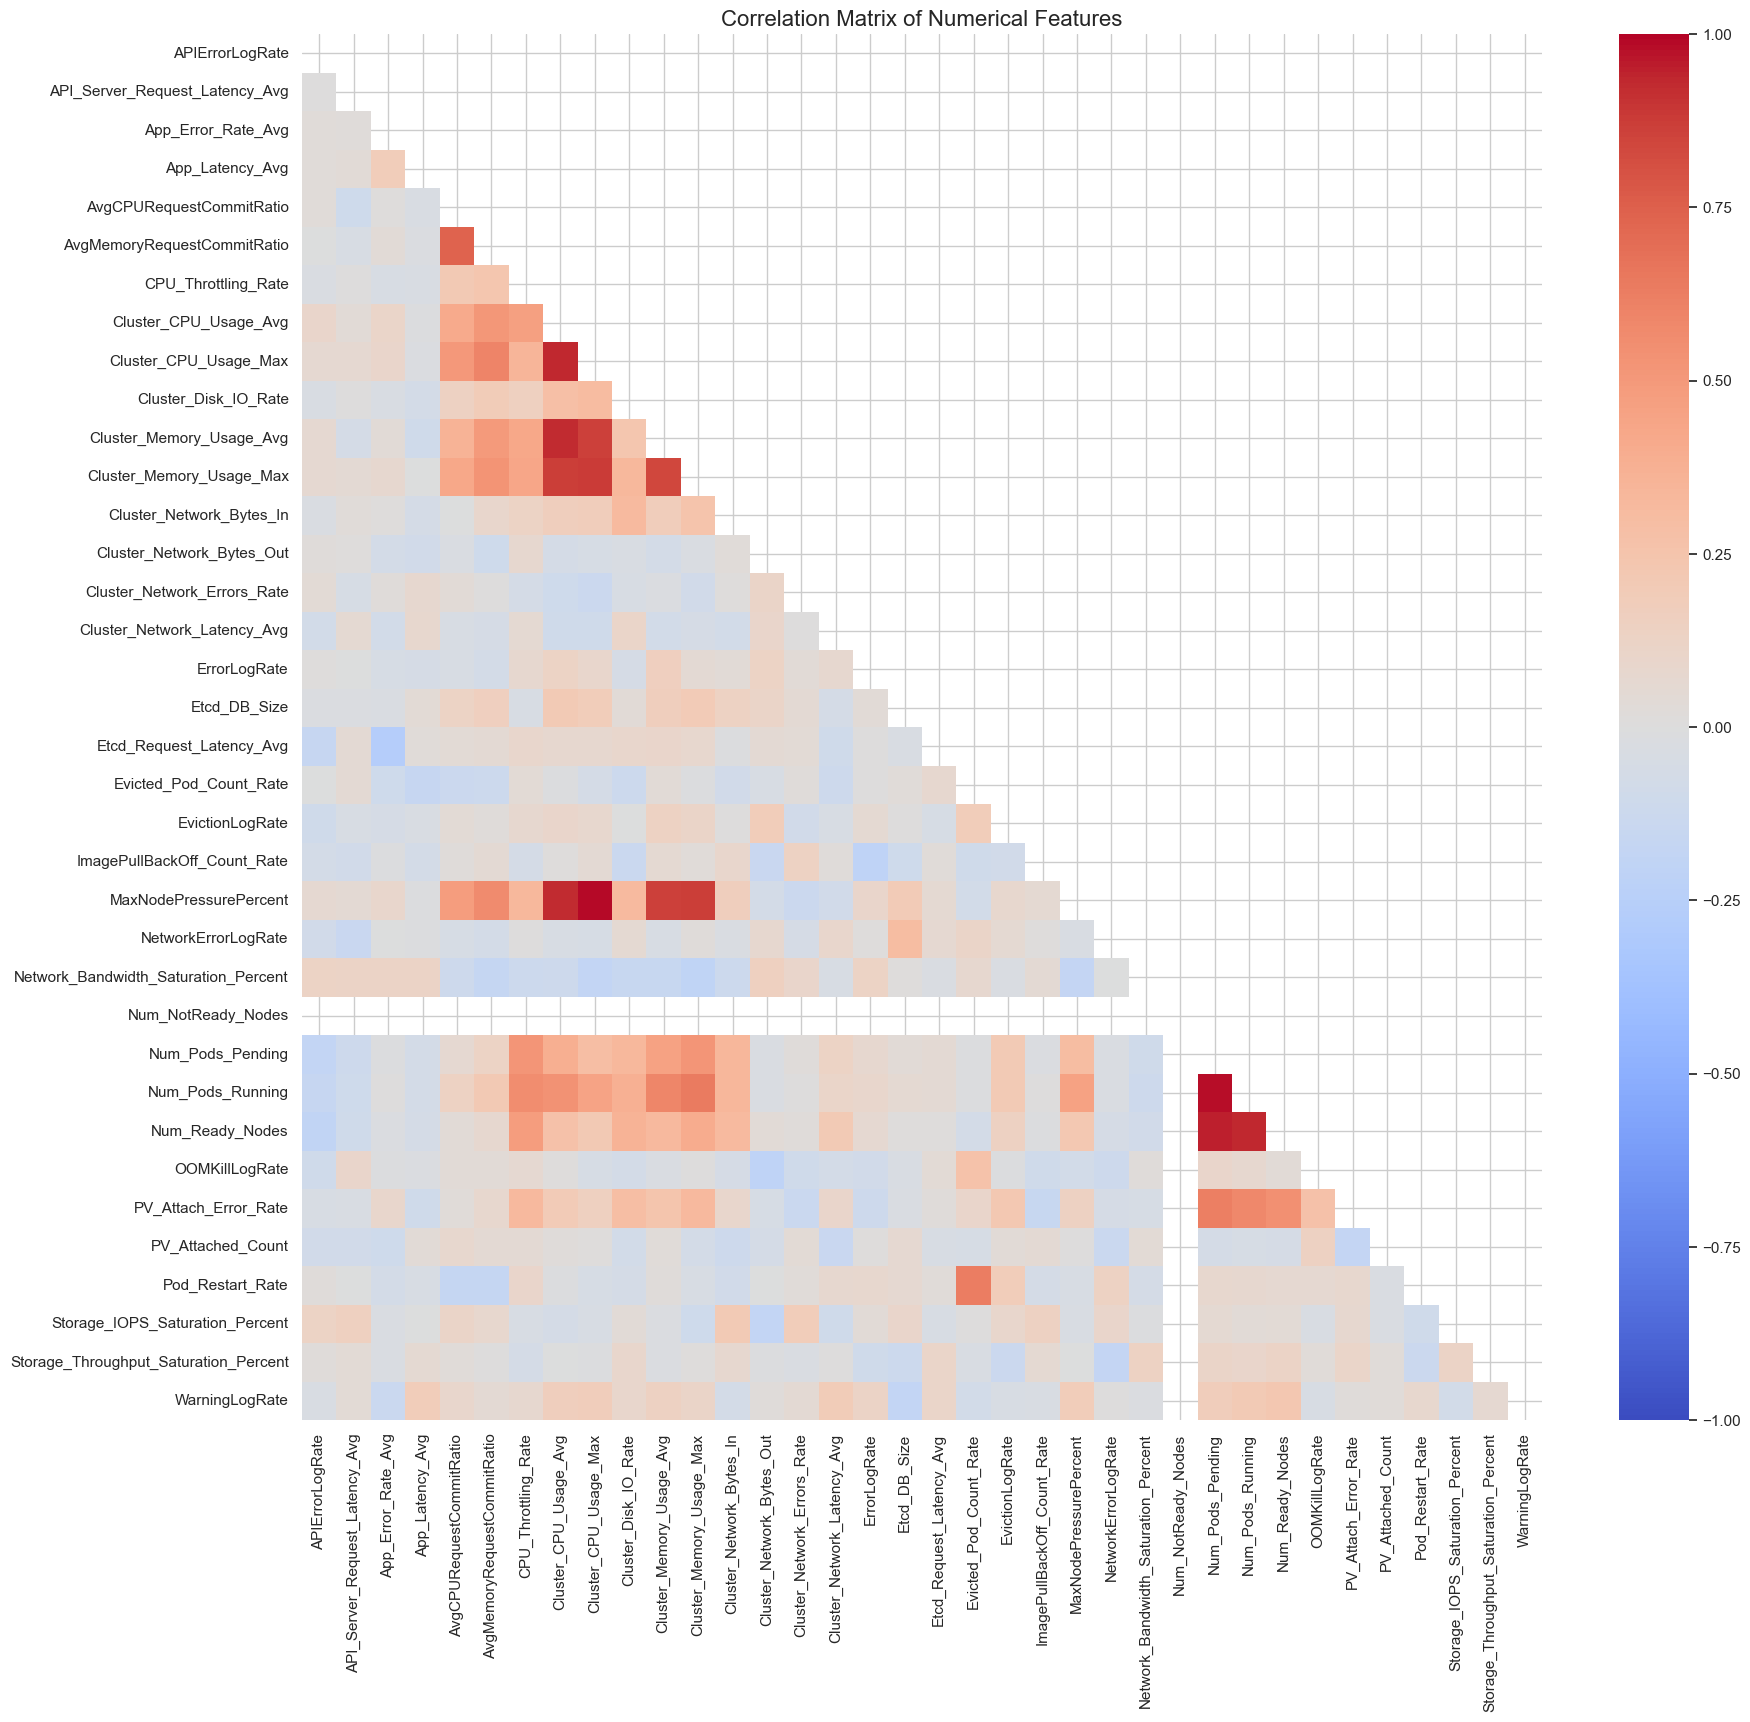


Pairs with absolute correlation > 0.8:
Cluster_CPU_Usage_Max     MaxNodePressurePercent      0.991944
Num_Pods_Running          Num_Pods_Pending            0.981136
Num_Ready_Nodes           Num_Pods_Pending            0.948816
Cluster_CPU_Usage_Max     Cluster_CPU_Usage_Avg       0.934019
Num_Pods_Running          Num_Ready_Nodes             0.930075
Cluster_CPU_Usage_Avg     MaxNodePressurePercent      0.928661
                          Cluster_Memory_Usage_Avg    0.924043
Cluster_CPU_Usage_Max     Cluster_Memory_Usage_Max    0.880132
Cluster_Memory_Usage_Max  Cluster_CPU_Usage_Avg       0.873770
MaxNodePressurePercent    Cluster_Memory_Usage_Max    0.872788
                          Cluster_Memory_Usage_Avg    0.866848
Cluster_Memory_Usage_Avg  Cluster_CPU_Usage_Max       0.865914
Cluster_Memory_Usage_Max  Cluster_Memory_Usage_Avg    0.842739
dtype: float64

Generating scatter plots for highly correlated pairs...


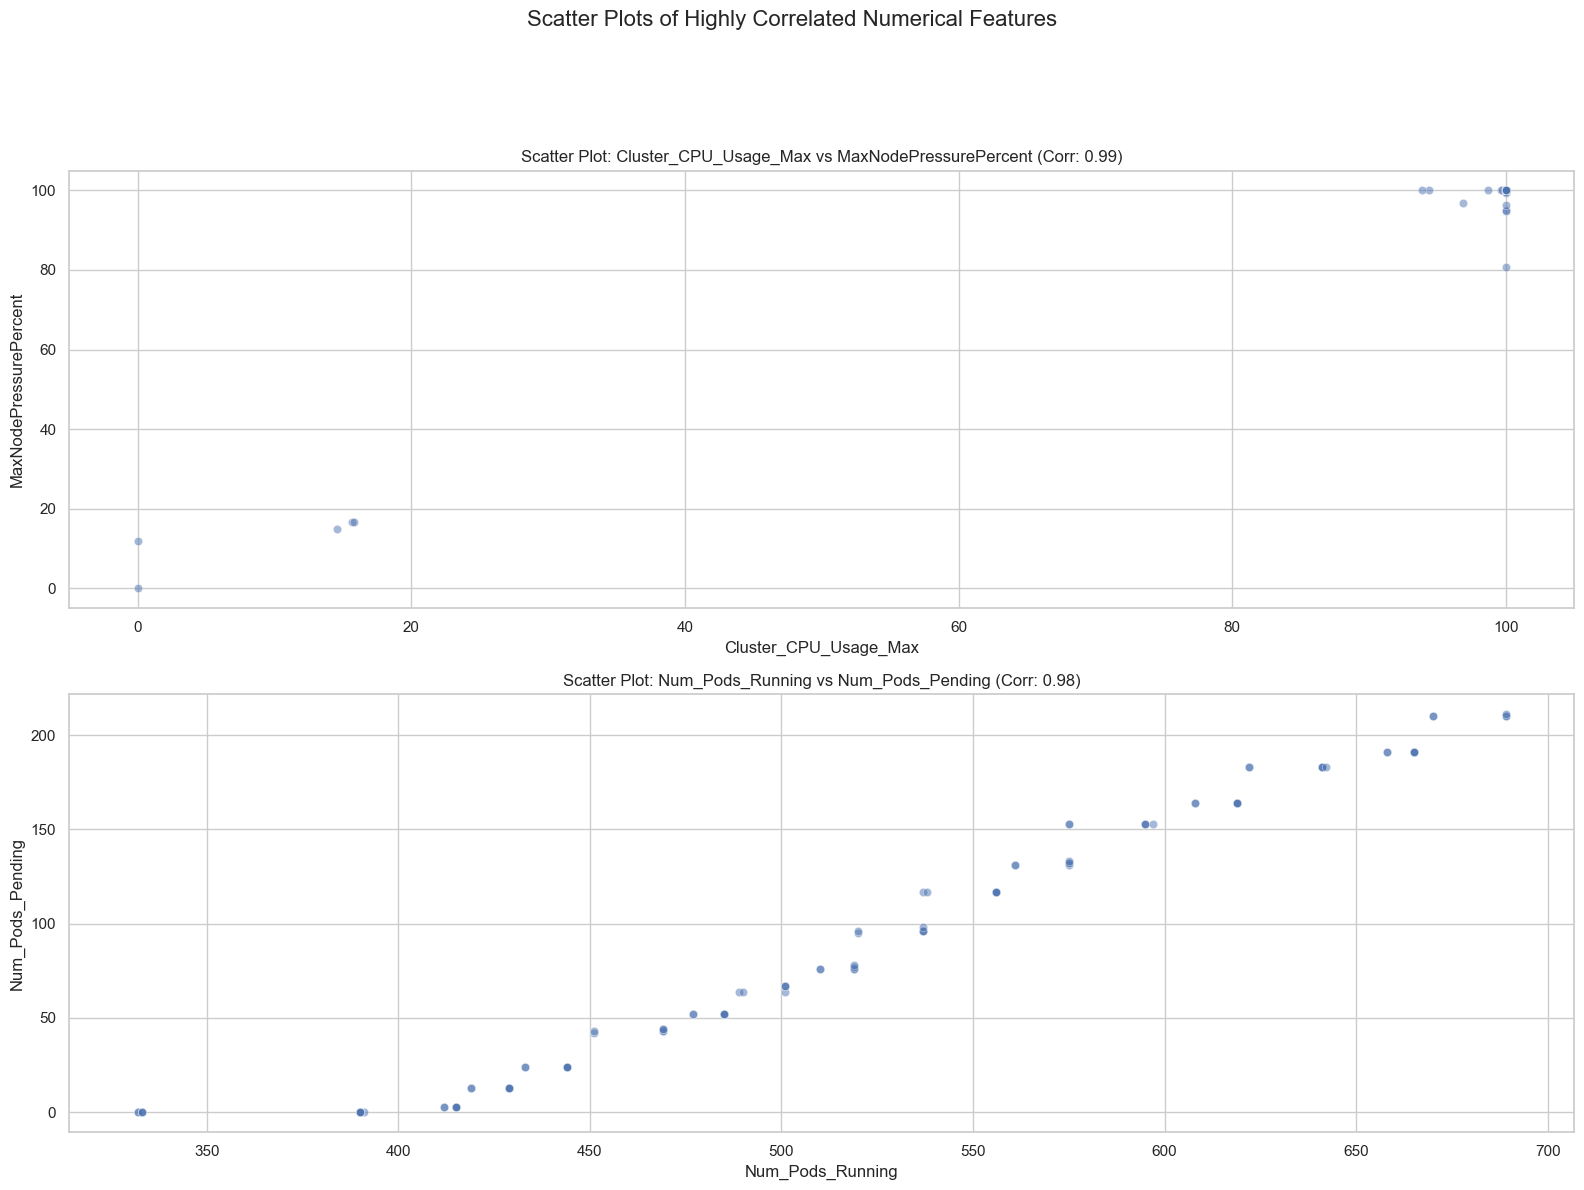


Generating box plots for numerical features vs. target ('Target_Failure_Type')...


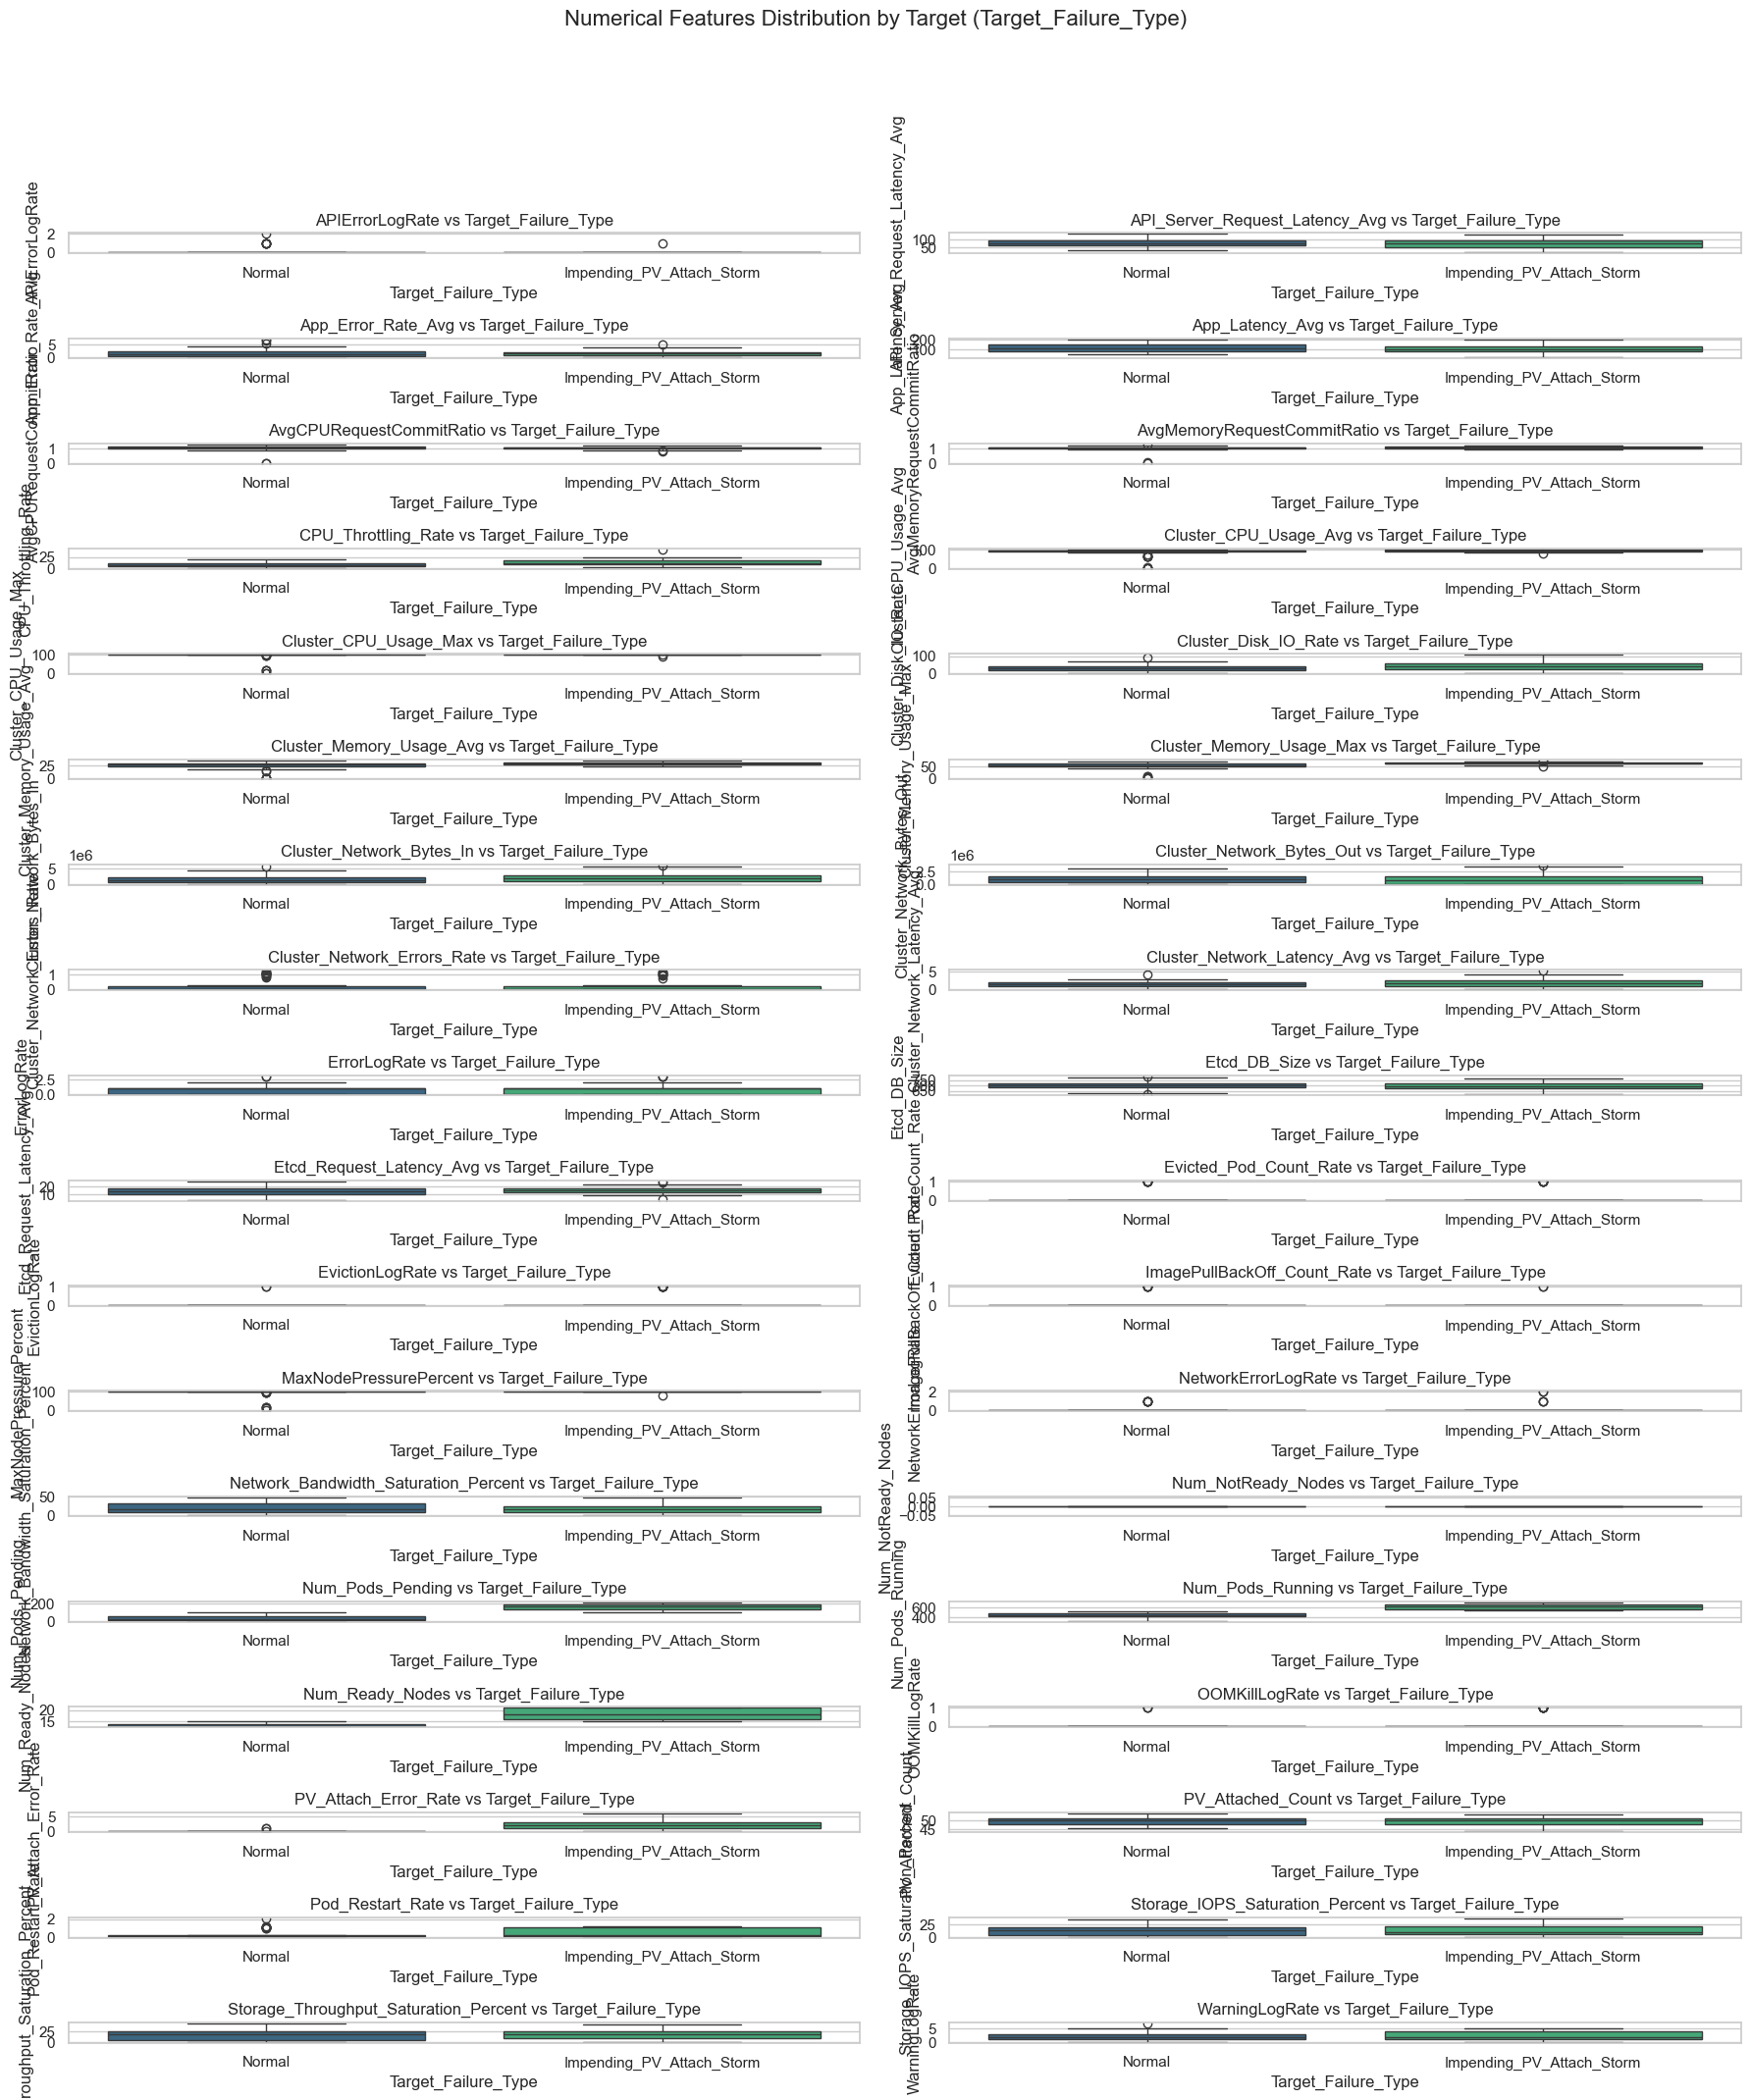


--- 7. Time Series Analysis ---

Generating time series plots for key numerical features...
Selected columns for time series plots: ['Cluster_Network_Bytes_In', 'Cluster_Network_Bytes_Out', 'Num_Pods_Running', 'Num_Pods_Pending', 'App_Latency_Avg']


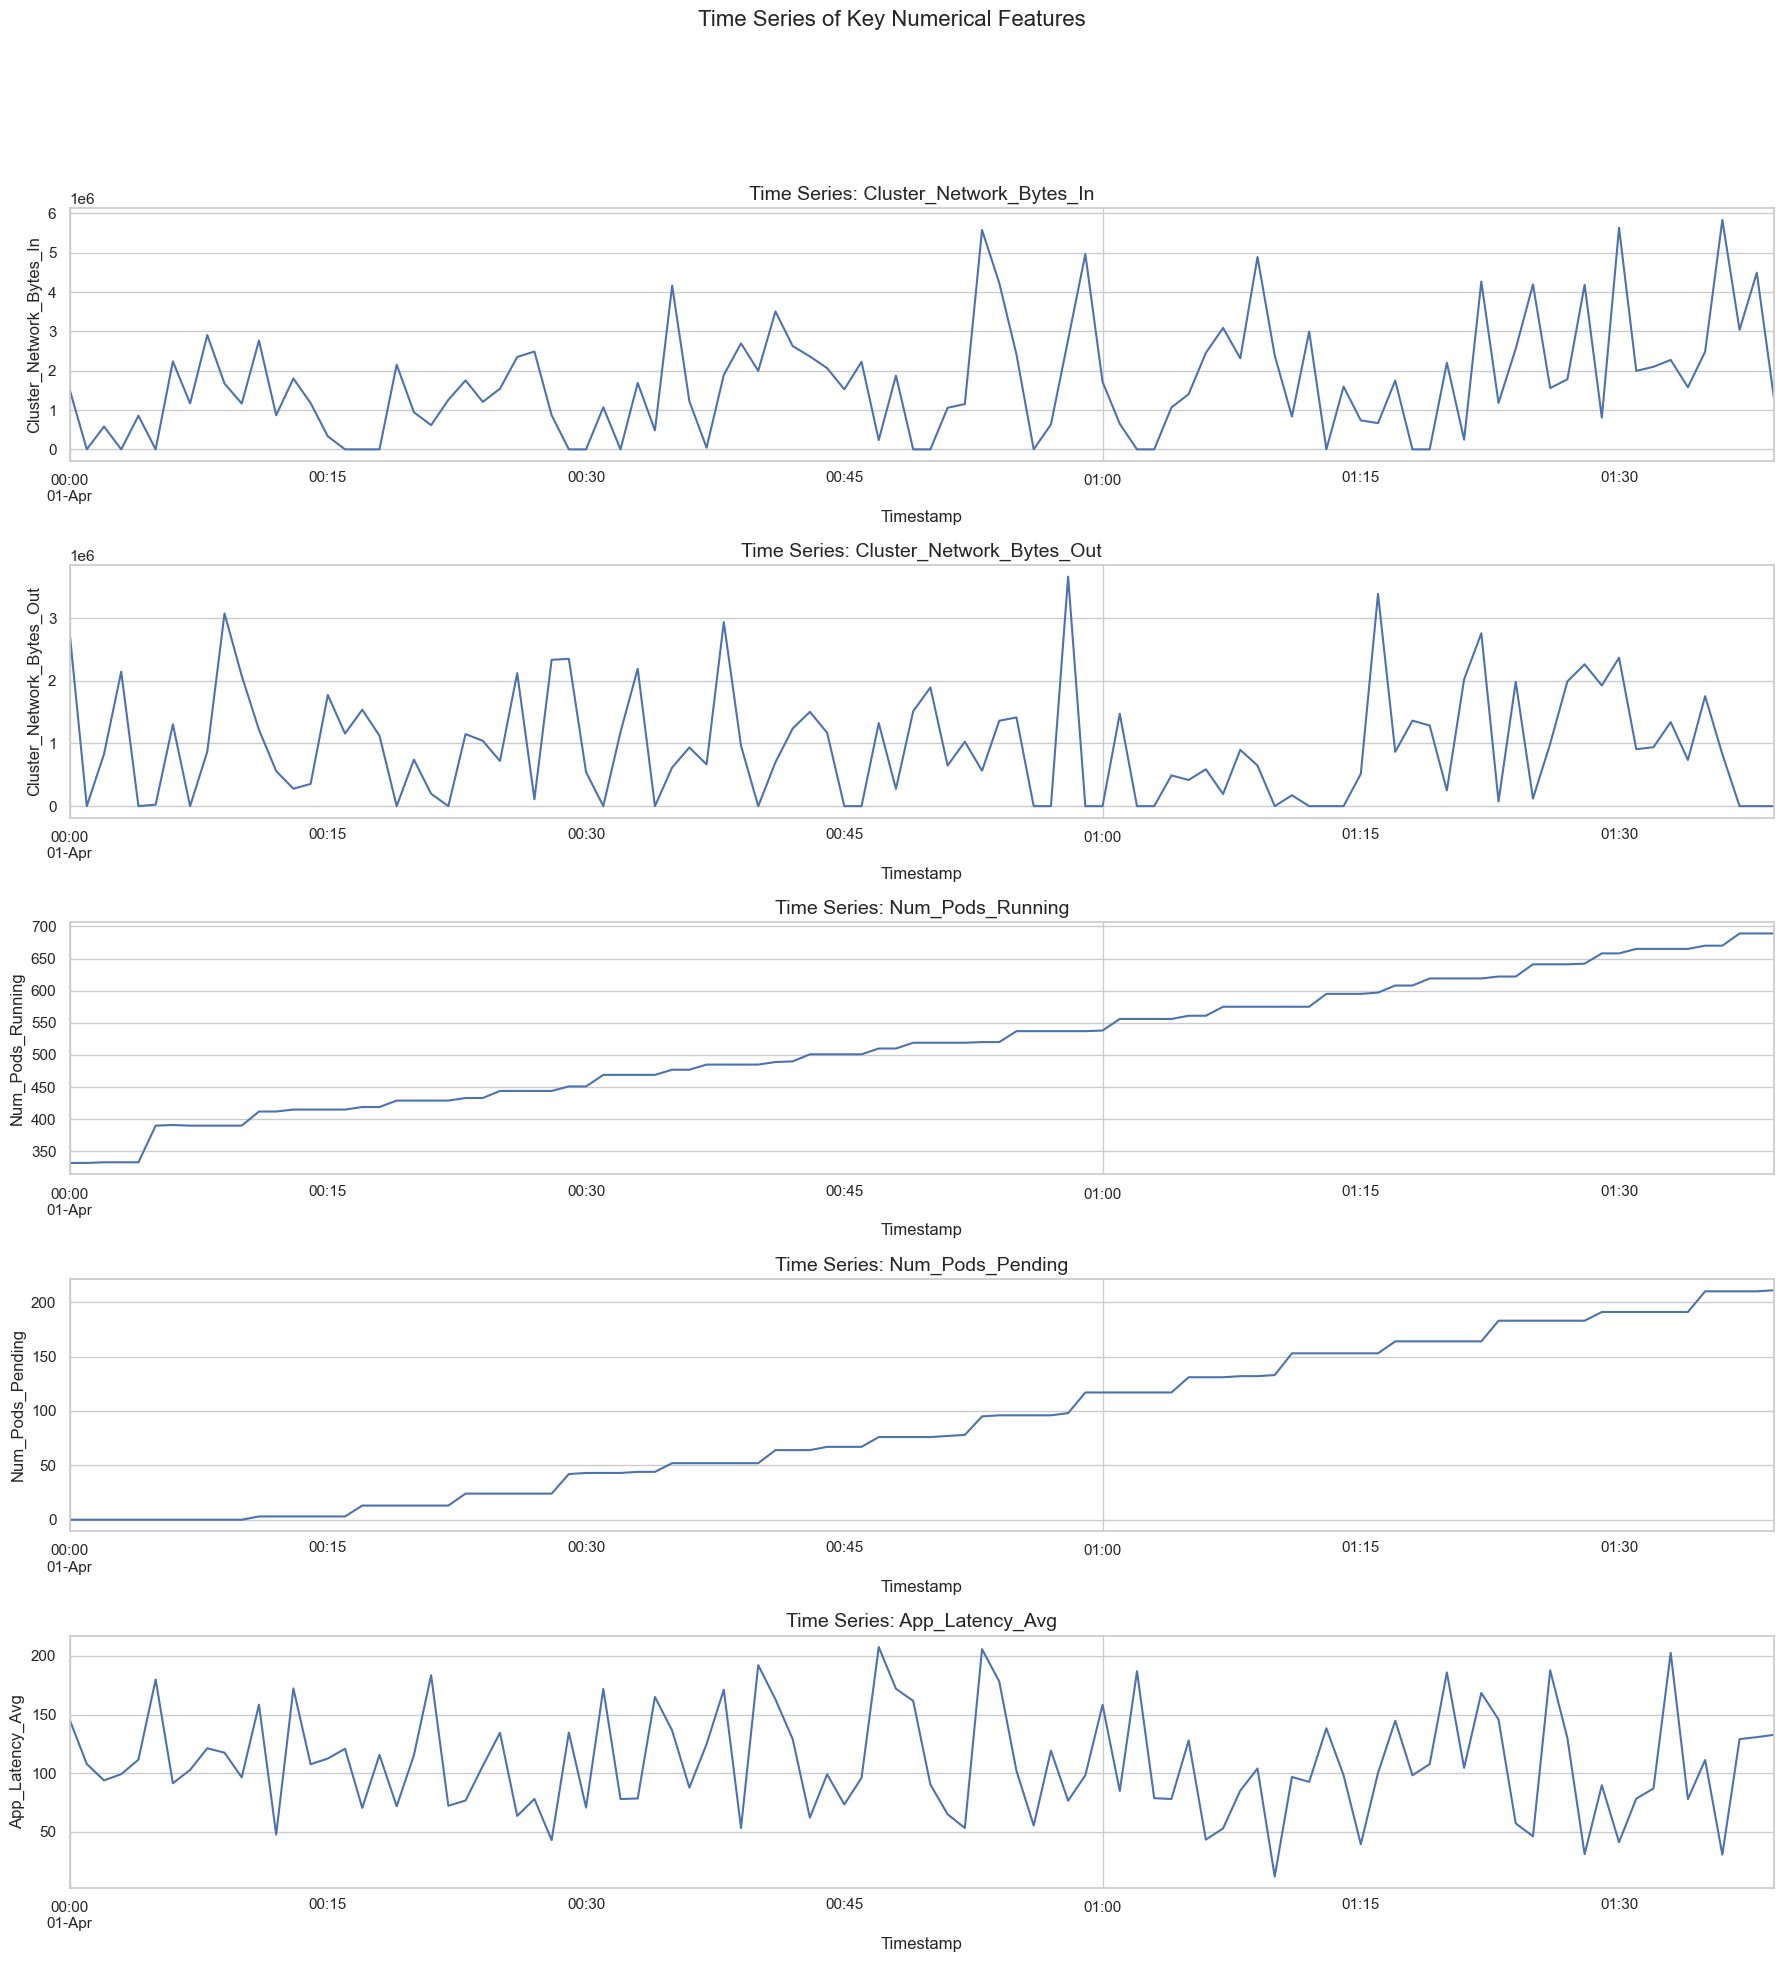


--- 8. EDA Conclusion ---
Exploratory Data Analysis complete.
Key findings and observations should be summarized based on the plots and statistics generated above.
Consider aspects like:
- Data quality (missing values, outliers, data types)
- Distributions of key features (skewness, modes)
- Relationships between features (correlations, potential multicollinearity)
- Trends over time for important metrics
- Differences in feature distributions based on the target variable (if applicable)

Further steps might include:
- More sophisticated outlier detection and handling.
- Feature engineering (creating new features from existing ones).
- Advanced time series modeling (decomposition, forecasting).
- Building predictive models (if there's a target variable).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Configuration ---
# Ignore warnings for cleaner output (optional)
warnings.filterwarnings('ignore')
# Set plot style
sns.set(style="whitegrid")
# Set default figure size
plt.rcParams['figure.figsize'] = (15, 7)
# Define the path to your data file
# **** IMPORTANT: Replace 'monitoring_data.csv' with the actual path to your extracted data file ****
DATA_FILE_PATH = 'synthetic_kubernetes_metrics_realistic_v7_3_balanced.csv' 

# --- 1. Load Data ---
print("--- 1. Loading Data ---")
try:
    # Assuming the first column is the timestamp and can be parsed as dates
    # If the timestamp format is different, you might need a 'parse_dates' or 'date_parser' argument
    df = pd.read_csv(DATA_FILE_PATH, parse_dates=[0]) 
    print(f"Successfully loaded data from {DATA_FILE_PATH}")
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_FILE_PATH}")
    print("Please ensure the data has been extracted from the image into a CSV file")
    print("and the DATA_FILE_PATH variable is set correctly.")
    # Exit if data cannot be loaded
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    print("Please check the CSV file format and column headers.")
    # Attempt to load without date parsing as a fallback
    try:
        print("Attempting to load without automatic date parsing...")
        df = pd.read_csv(DATA_FILE_PATH)
        print("Loaded data, but date parsing failed initially. Check the first column.")
    except Exception as e2:
        print(f"Fallback loading also failed: {e2}")
        exit()

# --- 2. Initial Data Inspection ---
print("\n--- 2. Initial Data Inspection ---")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# Display last few rows
print("\nLast 5 rows:")
print(df.tail())

# Get column names and data types
print("\nColumn Names and Data Types:")
print(df.info())

# It's highly likely the column names might be messy after OCR.
# Manually inspect df.columns and rename them if necessary. Example:
# df.columns = ['Timestamp', 'ApiErrorLogR', 'ApiR_AppErrorR', ... , 'Target_Failure'] 
# print("\nColumns after potential renaming:")
# print(df.columns)

# Identify the timestamp column (assuming it's the first one)
timestamp_col = df.columns[0]
print(f"\nIdentified timestamp column: {timestamp_col}")

# Identify potential target column (assuming it's the last one)
target_col = df.columns[-1]
print(f"Identified potential target column: {target_col}")

# Check data types again, especially for the timestamp
if pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
    print(f"\n'{timestamp_col}' is already a datetime type.")
    # Set timestamp as index - common practice for time series EDA
    try:
        df = df.set_index(timestamp_col)
        print(f"Set '{timestamp_col}' as the DataFrame index.")
    except Exception as e:
        print(f"Could not set '{timestamp_col}' as index: {e}")
else:
    print(f"\nAttempting to convert '{timestamp_col}' to datetime...")
    try:
        # Try converting the first column to datetime if parsing failed initially
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
        print(f"Successfully converted '{timestamp_col}' to datetime.")
        # Set timestamp as index
        df = df.set_index(timestamp_col)
        print(f"Set '{timestamp_col}' as the DataFrame index.")
    except Exception as e:
        print(f"Error converting '{timestamp_col}' to datetime: {e}")
        print("Timestamp analysis might be limited.")


# Identify numerical and categorical columns (heuristic)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nIdentified {len(numerical_cols)} numerical columns.")
print(f"Identified {len(categorical_cols)} categorical columns: {categorical_cols}")

# If the target column was read as numerical but should be categorical:
if target_col in numerical_cols:
     # Check unique values to see if it looks categorical
     if df[target_col].nunique() < 20: # Arbitrary threshold
         print(f"Converting potential target '{target_col}' to categorical type.")
         try:
            df[target_col] = df[target_col].astype('category')
            categorical_cols.append(target_col)
            numerical_cols.remove(target_col)
         except Exception as e:
            print(f"Could not convert '{target_col}' to category: {e}")

# --- 3. Handling Missing Values ---
print("\n--- 3. Handling Missing Values ---")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing_values, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Count'] > 0].sort_values('Percent', ascending=False)

if not missing_df.empty:
    print("\nMissing values found:")
    print(missing_df)
    # Basic strategy: fill numerical with median/mean, categorical with mode
    # More advanced imputation might be needed depending on the context
    print("\nApplying basic imputation (median for numerical, mode for categorical)...")
    for col in numerical_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            # print(f"Filled missing values in '{col}' with median ({median_val})")
    for col in categorical_cols:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            # print(f"Filled missing values in '{col}' with mode ({mode_val})")
    print("Missing value imputation complete (basic).")
else:
    print("\nNo missing values found.")

# --- 4. Descriptive Statistics ---
print("\n--- 4. Descriptive Statistics ---")
print("\nSummary statistics for numerical columns:")
# Use .describe(include='all') to see stats for categorical columns too
print(df[numerical_cols].describe().transpose())

if categorical_cols:
    print("\nSummary statistics for categorical columns:")
    print(df[categorical_cols].describe().transpose())

# --- 5. Univariate Analysis (Visualizing single variables) ---
print("\n--- 5. Univariate Analysis ---")

# 5.1 Histograms and Density Plots for Numerical Features
print("\nGenerating histograms and density plots for numerical features...")
# Reduce the number of plots if there are too many columns, or plot selectively
cols_to_plot_uni = numerical_cols # Plot all numerical by default
if len(numerical_cols) > 20:
    print(f"Warning: Plotting histograms for all {len(numerical_cols)} numerical columns. This might take a while and generate many plots.")
    # Option: Select a subset based on variance, importance, or domain knowledge
    # cols_to_plot_uni = df[numerical_cols].var().nlargest(20).index.tolist() 
    # print("Plotting for the top 20 columns by variance.")
    
plt.figure(figsize=(18, max(6, len(cols_to_plot_uni) * 0.5))) # Adjust height based on number of plots
for i, col in enumerate(cols_to_plot_uni):
    plt.subplot(len(cols_to_plot_uni), 2, 2*i + 1)
    sns.histplot(df[col], kde=False, bins=30)
    plt.title(f'Histogram: {col}')
    plt.xlabel('') # Reduce clutter

    plt.subplot(len(cols_to_plot_uni), 2, 2*i + 2)
    sns.kdeplot(df[col], fill=True)
    plt.title(f'Density Plot: {col}')
    plt.xlabel('') # Reduce clutter
    plt.ylabel('') # Reduce clutter

plt.suptitle('Distribution of Numerical Features', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# 5.2 Count Plots for Categorical Features
print("\nGenerating count plots for categorical features...")
if categorical_cols:
    plt.figure(figsize=(12, max(6, len(categorical_cols) * 4))) # Adjust height
    for i, col in enumerate(categorical_cols):
        plt.subplot(len(categorical_cols), 1, i + 1)
        sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')
        plt.title(f'Count Plot: {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
    plt.suptitle('Distribution of Categorical Features', y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No categorical columns identified for count plots.")

# --- 6. Bivariate Analysis (Relationships between variables) ---
print("\n--- 6. Bivariate Analysis ---")

# 6.1 Correlation Matrix Heatmap for Numerical Features
print("\nGenerating correlation heatmap for numerical features...")
if len(numerical_cols) > 1:
    plt.figure(figsize=(min(20, len(numerical_cols)), min(18, len(numerical_cols)))) # Adjust size
    correlation_matrix = df[numerical_cols].corr()
    mask = np.triu(correlation_matrix) # Mask for upper triangle
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", mask=mask, vmin=-1, vmax=1) 
    # Use annot=True only if the number of columns is small (e.g., < 20), otherwise it gets cluttered
    plt.title('Correlation Matrix of Numerical Features', fontsize=16)
    plt.show()

    # Print highly correlated pairs (absolute correlation > threshold)
    threshold = 0.80
    highly_correlated = correlation_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
    highly_correlated = highly_correlated[highly_correlated > threshold]
    highly_correlated = highly_correlated[highly_correlated < 1.0] # Exclude self-correlation
    print(f"\nPairs with absolute correlation > {threshold}:")
    if not highly_correlated.empty:
        print(highly_correlated)
    else:
        print("No pairs found above the threshold.")
else:
    print("Not enough numerical columns for a correlation matrix.")

# 6.2 Scatter Plots for selected pairs (e.g., highly correlated or feature vs target)
# Select a few pairs based on correlation or interest
# Example: Plotting the top 2 most correlated pairs
if 'highly_correlated' in locals() and not highly_correlated.empty:
    print("\nGenerating scatter plots for highly correlated pairs...")
    pairs_to_plot = highly_correlated.head(2).index.tolist() # Plot top 2
    plt.figure(figsize=(16, 6 * len(pairs_to_plot)))
    for i, (col1, col2) in enumerate(pairs_to_plot):
        plt.subplot(len(pairs_to_plot), 1, i + 1)
        sns.scatterplot(x=df[col1], y=df[col2], alpha=0.5)
        plt.title(f'Scatter Plot: {col1} vs {col2} (Corr: {correlation_matrix.loc[col1, col2]:.2f})')
    plt.suptitle('Scatter Plots of Highly Correlated Numerical Features', y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 6.3 Box Plots: Numerical features vs. Categorical target/features
if target_col in categorical_cols and numerical_cols:
    print(f"\nGenerating box plots for numerical features vs. target ('{target_col}')...")
    # Select a subset of numerical features if too many
    cols_to_plot_box = numerical_cols 
    if len(numerical_cols) > 20:
        print(f"Warning: Plotting box plots for all {len(numerical_cols)} numerical columns vs target. Selecting a subset might be clearer.")
        # Example: Select top 10 by variance
        # cols_to_plot_box = df[numerical_cols].var().nlargest(10).index.tolist()

    plt.figure(figsize=(18, max(6, len(cols_to_plot_box) * 0.6)))
    for i, col in enumerate(cols_to_plot_box):
        plt.subplot((len(cols_to_plot_box) + 1) // 2, 2, i + 1) # Arrange in 2 columns
        sns.boxplot(x=df[target_col], y=df[col], palette='viridis')
        plt.title(f'{col} vs {target_col}')
        plt.xlabel(target_col)
        plt.ylabel(col)
    plt.suptitle(f'Numerical Features Distribution by Target ({target_col})', y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
elif categorical_cols:
    print("\nNo clear target column identified as categorical, skipping target-based box plots.")
else:
    print("\nSkipping box plots as no categorical features were identified.")


# --- 7. Time Series Analysis ---
print("\n--- 7. Time Series Analysis ---")

if pd.api.types.is_datetime64_any_dtype(df.index):
    print("\nGenerating time series plots for key numerical features...")
    # Select key columns to plot over time (e.g., based on variance, domain knowledge)
    # Avoid plotting too many at once, as it becomes unreadable.
    key_cols_time = []
    if len(numerical_cols) > 0:
        # Example: Select columns containing 'CPU', 'Memory', 'Error', 'Latency' or plot top 5 by variance
        potential_keys = [col for col in numerical_cols if any(k in col for k in ['CPU', 'Mem', 'Error', 'Latency', 'Fail', 'Req'])]
        if len(potential_keys) > 0 and len(potential_keys) <= 10:
             key_cols_time = potential_keys
        else:
             key_cols_time = df[numerical_cols].var().nlargest(min(5, len(numerical_cols))).index.tolist() # Plot top 5 variance if keywords don't match well
        
        print(f"Selected columns for time series plots: {key_cols_time}")

        if key_cols_time:
            plt.figure(figsize=(18, len(key_cols_time) * 4)) # Adjust height
            for i, col in enumerate(key_cols_time):
                plt.subplot(len(key_cols_time), 1, i + 1)
                df[col].plot(linewidth=1.5)
                plt.title(f'Time Series: {col}', fontsize=14)
                plt.xlabel('Timestamp')
                plt.ylabel(col)
                # Optional: Add rolling mean/std
                # df[col].rolling(window=60).mean().plot(label='60min Rolling Mean', linestyle='--') # Example: 1-hour rolling mean
                # plt.legend()
            plt.suptitle('Time Series of Key Numerical Features', y=1.01, fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        else:
            print("Could not automatically select key columns for time series plots.")
    else:
        print("No numerical columns to plot over time.")
        
    # Resampling example (e.g., hourly average)
    # print("\nExample: Resampling data to hourly averages...")
    # try:
    #     df_hourly = df[numerical_cols].resample('H').mean() # 'H' for hourly, 'D' for daily etc.
    #     print(df_hourly.head())
    #     # You could then plot the resampled data
    #     df_hourly[key_cols_time].plot(subplots=True, layout=(-1, 1), figsize=(15, len(key_cols_time)*3), title="Hourly Averages")
    #     plt.tight_layout()
    #     plt.show()
    # except Exception as e:
    #     print(f"Could not resample data: {e}")
        
else:
    print("\nSkipping time series analysis as the index is not a datetime type.")


# --- 8. Conclusion ---
print("\n--- 8. EDA Conclusion ---")
print("Exploratory Data Analysis complete.")
print("Key findings and observations should be summarized based on the plots and statistics generated above.")
print("Consider aspects like:")
print("- Data quality (missing values, outliers, data types)")
print("- Distributions of key features (skewness, modes)")
print("- Relationships between features (correlations, potential multicollinearity)")
print("- Trends over time for important metrics")
print("- Differences in feature distributions based on the target variable (if applicable)")
print("\nFurther steps might include:")
print("- More sophisticated outlier detection and handling.")
print("- Feature engineering (creating new features from existing ones).")
print("- Advanced time series modeling (decomposition, forecasting).")
print("- Building predictive models (if there's a target variable).")